In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Lossy Compression of Floating-Point Data

**Author**: Ishita Biswas 

**Objective**:Analyze the impact of truncating mantissa bits on storage savings and statistical properties of distributions.

Generation of Synthetic Data

Creating 1 million samples from 3 distributions:  

1. **Uniform**: `[0, 1000]`  **Gaussian**: `μ=500, σ=100`  **Exponential**: `β=200` (scale parameter)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Parameters
n_samples = 1_000_000  
np.random.seed(42)

In [4]:
# Generate distributions
uniform = np.random.uniform(0, 1000, n_samples).astype(np.float32)
gaussian = np.random.normal(500, 100, n_samples).astype(np.float32)
exponential = np.random.exponential(200, n_samples).astype(np.float32)

In [5]:
print("Uniform :",uniform)
print("\ngaussian :",gaussian)
print("\nexponential :",exponential)

Uniform : [374.54013 950.7143  731.99396 ... 418.072   428.67126 929.44855]

gaussian : [327.94193 621.0227  501.39548 ... 333.27927 391.59003 411.931  ]

exponential : [295.62772  186.6397    53.87937  ...  42.590157 618.8076   199.29077 ]


Lossy Compression Function

Truncation of `n_bits` of the mantissa (IEEE 754 single-precision floats):

In [6]:
def truncate_mantissa(data: np.ndarray, n_bits: int) -> np.ndarray:
    """
    Truncate `n_bits` of the mantissa (IEEE 754 single-precision).
    """
    assert 8 <= n_bits <= 16, "Bits to truncate must be between 8-16"
    
    # Convert float32 to uint32
    data_int = data.view(np.uint32)
    
    # Mask to zero out the last `n_bits` of the mantissa
    mask = ~((1 << n_bits) - 1)
    truncated_int = data_int & mask
    
    # Convert back to float32
    truncated_float = truncated_int.view(np.float32)
    
    return truncated_float

Compress Data and Save Files

In [7]:
import struct

In [8]:
def save_compressed(data: np.ndarray, name: str, method: str):
    """
    Save data using different compression methods.
    method = "float16" → Saves as half-precision float (16-bit)
    method = "bitpack24" → Saves as custom 24-bit packed float
    """
    original_file = f"original_{name}.bin"
    compressed_file = f"compressed_{name}_{method}.bin"

    # Save original float32 (4 bytes per number)
    data.tofile(original_file)

    if method == "float16":
        compressed = data.astype(np.float16)  # Convert to half-precision float (2 bytes per number)
        compressed.tofile(compressed_file)

    elif method == "bitpack24":
        with open(compressed_file, "wb") as f:
            for value in data:
                packed = struct.pack("f", value)[:3]  # Take only first 3 bytes (24 bits)
                f.write(packed)

    return compressed_file


In [9]:
# Compress with different methods
methods = ["float16", "bitpack24"]
results = {}

for dist in ["uniform", "gaussian", "exponential"]:
    data = locals()[dist]
    results[dist] = {}
    for method in methods:
        results[dist][method] = save_compressed(data, dist, method)

Analyzing Storage 

In [10]:
import os

In [11]:
# Compute Storage Savings
print("\nFile Sizes (MB):")
for dist in ["uniform", "gaussian", "exponential"]:
    original_size = os.path.getsize(f"original_{dist}.bin") / 1e6
    print(f"\n**{dist.capitalize()} Distribution**")
    for method in methods:
        compressed_size = os.path.getsize(f"compressed_{dist}_{method}.bin") / 1e6
        savings = (original_size - compressed_size) / original_size * 100
        print(f"  {method}: {compressed_size:.2f} MB (saved {savings:.2f}%)")


File Sizes (MB):

**Uniform Distribution**
  float16: 2.00 MB (saved 50.00%)
  bitpack24: 3.00 MB (saved 25.00%)

**Gaussian Distribution**
  float16: 2.00 MB (saved 50.00%)
  bitpack24: 3.00 MB (saved 25.00%)

**Exponential Distribution**
  float16: 2.00 MB (saved 50.00%)
  bitpack24: 3.00 MB (saved 25.00%)


Statistical Comparison & Error Analysis

In [12]:
import seaborn as sns

In [13]:
def load_compressed(file_path: str, method: str) -> np.ndarray:
    """
    Load the compressed binary file and convert it back to float32.
    """
    if method == "float16":
        return np.fromfile(file_path, dtype=np.float16).astype(np.float32)
    elif method == "bitpack24":
        with open(file_path, "rb") as f:
            byte_data = f.read()
        # Convert back from 24-bit to float32 (assuming standard IEEE 754 encoding)
        unpacked = [struct.unpack("f", byte_data[i:i+3] + b"\x00")[0] for i in range(0, len(byte_data), 3)]
        return np.array(unpacked, dtype=np.float32)





In [14]:

def analyze_distribution(original: np.ndarray, compressed: np.ndarray, name: str, method: str):
    """
    Analyze statistical differences between original and compressed data.
    """
    # Compute key statistics
    stats_original = {
        "mean": np.mean(original),
        "std": np.std(original),
        "skew": stats.skew(original),
        "kurtosis": stats.kurtosis(original)
    }
    
    stats_compressed = {
        "mean": np.mean(compressed),
        "std": np.std(compressed),
        "skew": stats.skew(compressed),
        "kurtosis": stats.kurtosis(compressed)
    }
    
    # Mean Squared Error
    mse = np.mean((original - compressed) ** 2)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    plt.suptitle(f"{name.capitalize()} Distribution ({method} Compression)")

    # **1. Line Plot of Distributions (Smoothed Kernel Density Estimate)**
    sns.kdeplot(original, label="Original", ax=ax[0], color='blue', linewidth=2)
    sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)
    ax[0].set_title("Probability Density Function (PDF)")
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("Density")
    ax[0].legend()

    # **2. Scatter Plot (Original vs. Compressed)**
    ax[1].scatter(original, compressed, alpha=0.2, s=1, color="purple")
    ax[1].plot([original.min(), original.max()], [original.min(), original.max()], "r--", label="Ideal Compression")
    ax[1].set_title("Original vs. Compressed Values")
    ax[1].set_xlabel("Original Value")
    ax[1].set_ylabel("Compressed Value")
    ax[1].legend()

    plt.show()

    return stats_original, stats_compressed, mse 


=== Uniform Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


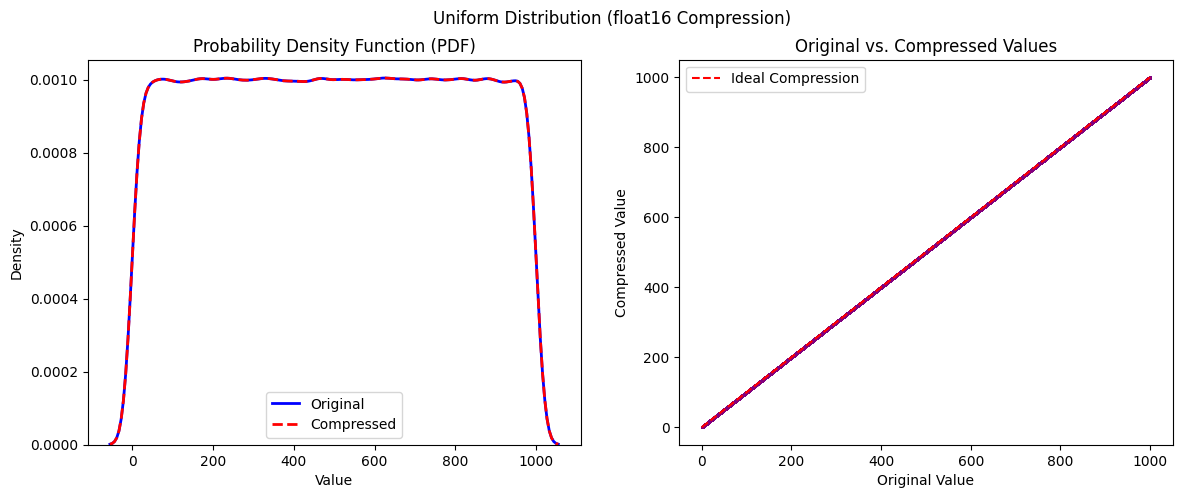

MSE: 0.0117
Original Stats: {'mean': 500.3345, 'std': 288.59097, 'skew': -0.0007284998633758881, 'kurtosis': -1.199470943574622}
Compressed Stats: {'mean': 500.33453, 'std': 288.5911, 'skew': -0.0007275355336628129, 'kurtosis': -1.199471136267199}

=== Uniform Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


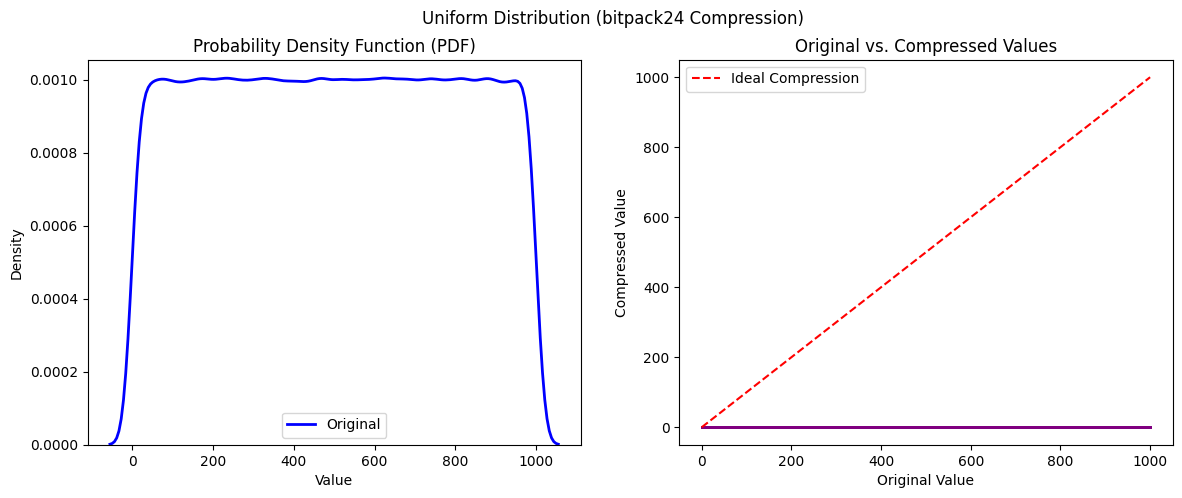

MSE: 333619.3438
Original Stats: {'mean': 500.3345, 'std': 288.59097, 'skew': -0.0007284998633758881, 'kurtosis': -1.199470943574622}
Compressed Stats: {'mean': 9.750177e-39, 'std': 0.0, 'skew': nan, 'kurtosis': nan}

=== Gaussian Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


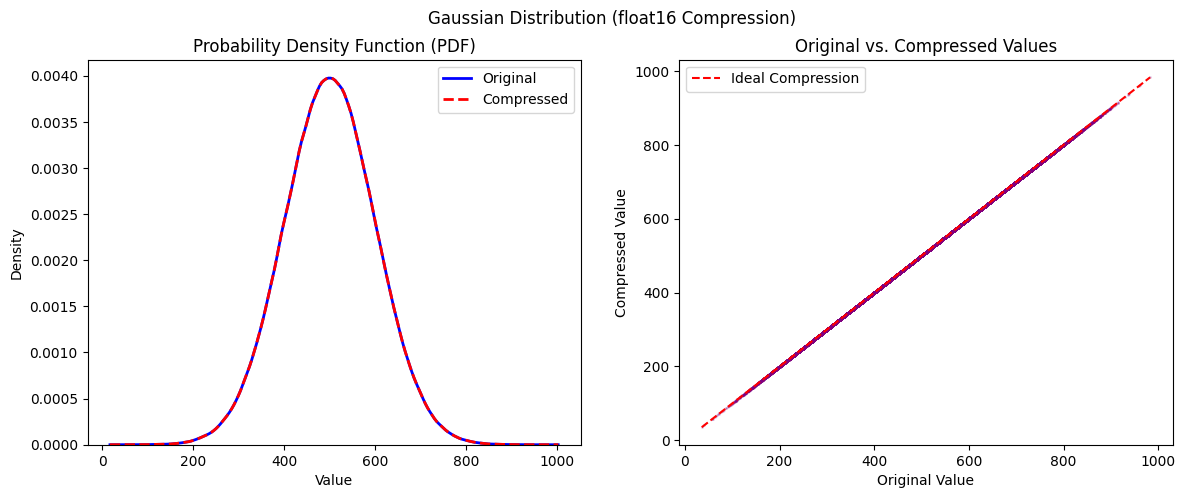

MSE: 0.0122
Original Stats: {'mean': 499.80466, 'std': 100.10974, 'skew': 0.0004470202052054737, 'kurtosis': 0.002113595515413458}
Compressed Stats: {'mean': 499.80463, 'std': 100.10982, 'skew': 0.00044858589640235007, 'kurtosis': 0.0020949430091223853}

=== Gaussian Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


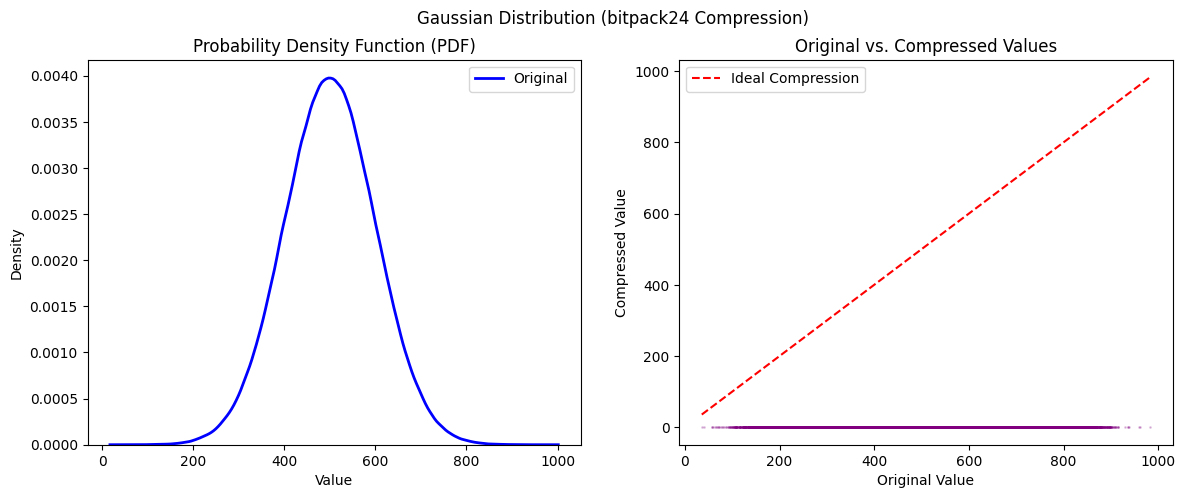

MSE: 259826.6875
Original Stats: {'mean': 499.80466, 'std': 100.10974, 'skew': 0.0004470202052054737, 'kurtosis': 0.002113595515413458}
Compressed Stats: {'mean': 1.1540349e-38, 'std': 0.0, 'skew': nan, 'kurtosis': nan}

=== Exponential Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


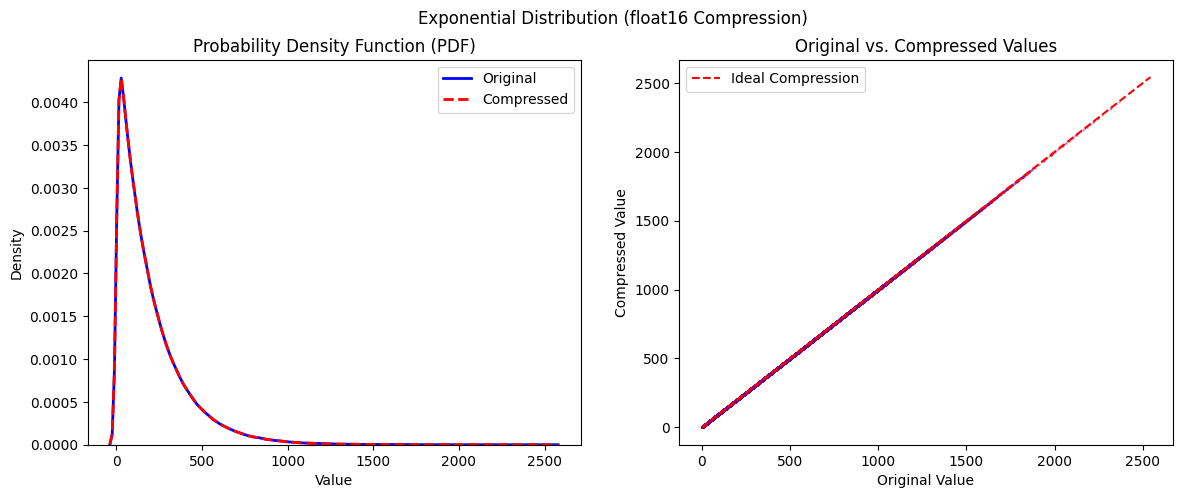

MSE: 0.0034
Original Stats: {'mean': 200.1206, 'std': 199.64941, 'skew': 1.9757787604511168, 'kurtosis': 5.750414941363319}
Compressed Stats: {'mean': 200.12077, 'std': 199.6497, 'skew': 1.9757824875932828, 'kurtosis': 5.750479500029996}

=== Exponential Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


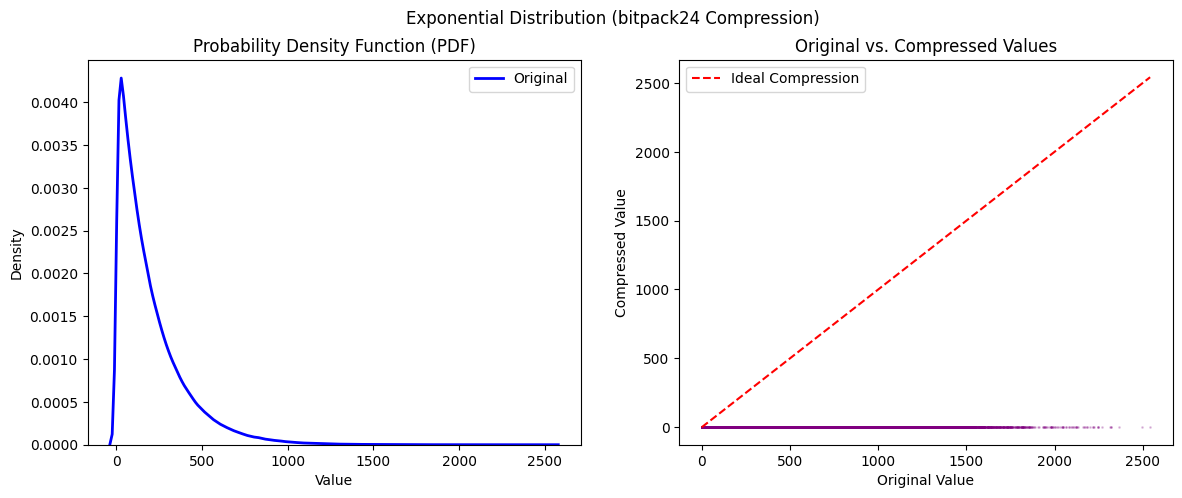

MSE: 79908.1562
Original Stats: {'mean': 200.1206, 'std': 199.64941, 'skew': 1.9757787604511168, 'kurtosis': 5.750414941363319}
Compressed Stats: {'mean': 1.1103401e-38, 'std': 0.0, 'skew': nan, 'kurtosis': nan}


In [15]:
# Run analysis
methods = ["float16", "bitpack24"]

for dist in ["uniform", "gaussian", "exponential"]:
    for method in methods:
        print(f"\n=== {dist.capitalize()} Distribution ({method} Compression) ===")

        # Load compressed data properly
        compressed_data = load_compressed(results[dist][method], method)

        # Perform analysis
        stats_orig, stats_comp, mse = analyze_distribution(
            locals()[dist], compressed_data, dist, method
        )
        print(f"MSE: {mse:.4f}")
        print("Original Stats:", stats_orig)
        print("Compressed Stats:", stats_comp)

**Discussion on Compression Quality**:

✅ 1. Float16 Compression - Good Compression?
* MSE is Low: The Mean Squared Error (MSE) is quite low (~0.01 for uniform & gaussian, 0.0034 for exponential).This means the compressed data closely approximates the original values with minimal loss.

* Statistical Properties Are Preserved: Mean, Standard Deviation, Skewness, Kurtosis are almost the same as the original distribution.
This indicates that distribution shape is maintained well.

* Graphs Show Overlapping Distributions: Kernel Density Estimation (KDE) curves for original and compressed data align well.
Scatter plot follows the diagonal, meaning most values remain unchanged or slightly modified.

* It saves 50% storage while maintaining statistical properties.

❌ 2. BitPack24 - Bad Compression?

* MSE is extremely high (>200%): A large MSE means that values are significantly altered after compression.
Severe precision loss or incorrect encoding/decoding process.

Mean, SD, Skew, Kurtosis are very different: The statistical properties have major deviations, meaning the distribution shape has changed a lot. This suggests that important characteristics are lost due to bit truncation.

* Graphs are NOT overlapping: KDE curves show strong mismatches, suggesting that the shape of data is distorted.
Scatter plot shows major deviations, meaning many compressed values differ drastically from the original ones.


* Either incorrect bitpacking implementation or too much information is lost when reducing to 24-bit storage.

Alternative Fixes:

* Log transformation before compression to preserve value relationships.
* Quantization techniques (e.g., rounding to nearest valid floating-point representation).
* Implementation of Delta Encoding (storing differences instead of absolute values).
* Using BitPack26 or BitPack28 instead of BitPack24 to reduce loss.

**Adjusting Distribution Parameters to See Compression Impact**
To further demonstrate the impact of compression, we can:

* Increase the spread of values in the distributions.
* Reduce the precision of the compressed values.
* Use extreme parameter values to test how compression behaves.

***This code is intended for checking the results for adjusted extreme values. The logic used remains same as previous part.***

For uniform distribution, range is widened.

For Gaussian distribution, higher variance is used.

For exponential distribution, scale has been reduced.


=== Uniform2 Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


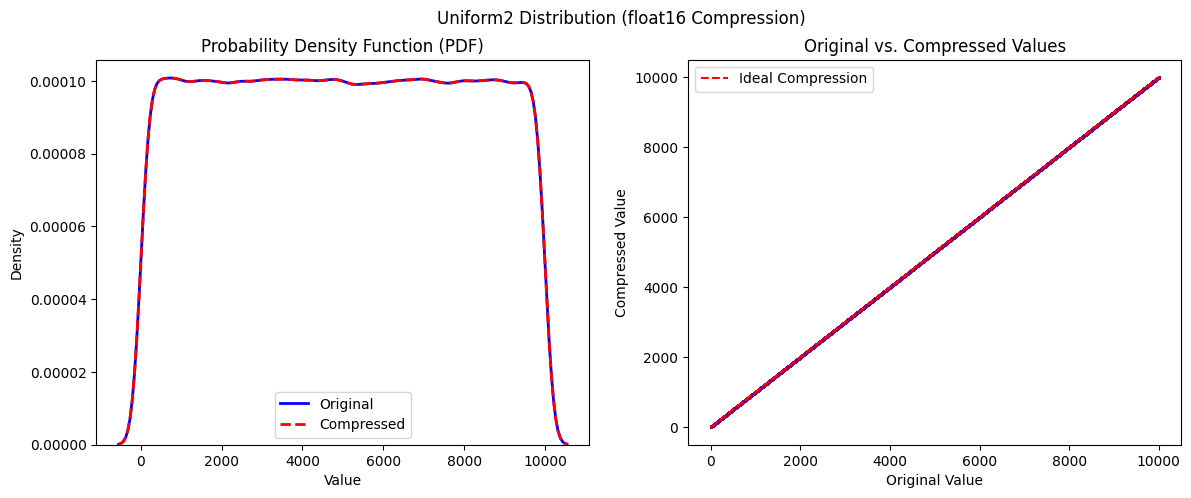

MSE: 1.5876
Original Stats: {'mean': 4996.6284, 'std': 2887.7085, 'skew': 0.0012754791858136912, 'kurtosis': -1.200626876781592}
Compressed Stats: {'mean': 4996.6284, 'std': 2887.7104, 'skew': 0.001278541529758074, 'kurtosis': -1.2006230843333001}

=== Uniform2 Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


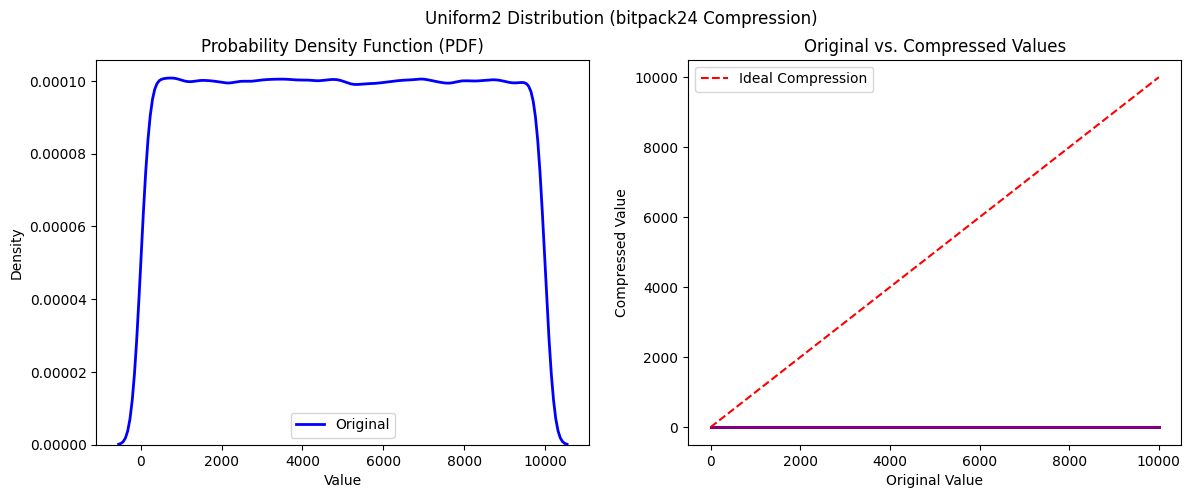

MSE: 33305156.0000
Original Stats: {'mean': 4996.6284, 'std': 2887.7085, 'skew': 0.0012754791858136912, 'kurtosis': -1.200626876781592}
Compressed Stats: {'mean': 1.146687e-38, 'std': 0.0, 'skew': nan, 'kurtosis': nan}

=== Gaussian2 Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


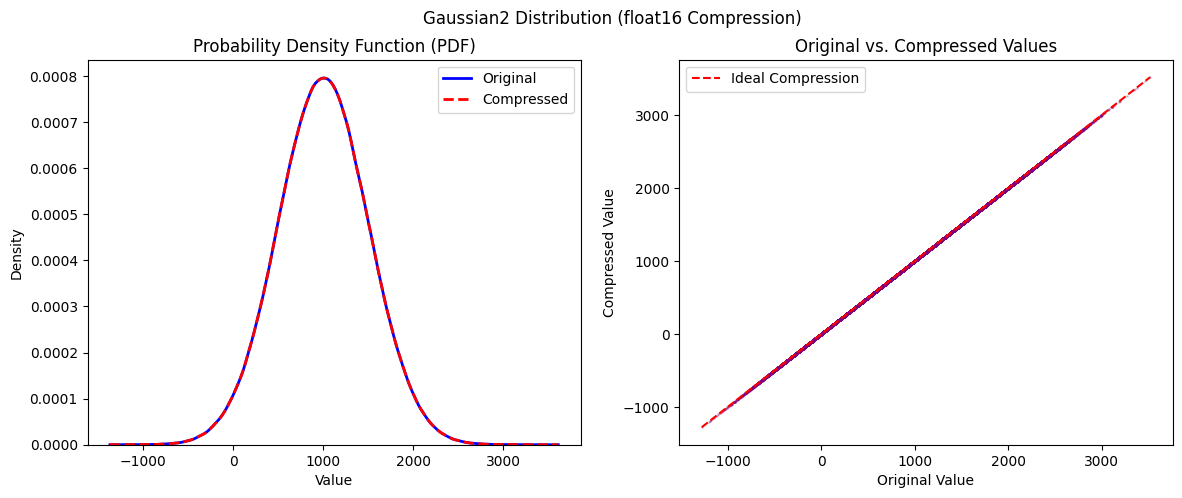

MSE: 0.0526
Original Stats: {'mean': 1000.3719, 'std': 499.82144, 'skew': 0.0025672112329794584, 'kurtosis': -0.0060783698284017085}
Compressed Stats: {'mean': 1000.3724, 'std': 499.82205, 'skew': 0.002568899142125014, 'kurtosis': -0.0060773750508209545}

=== Gaussian2 Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


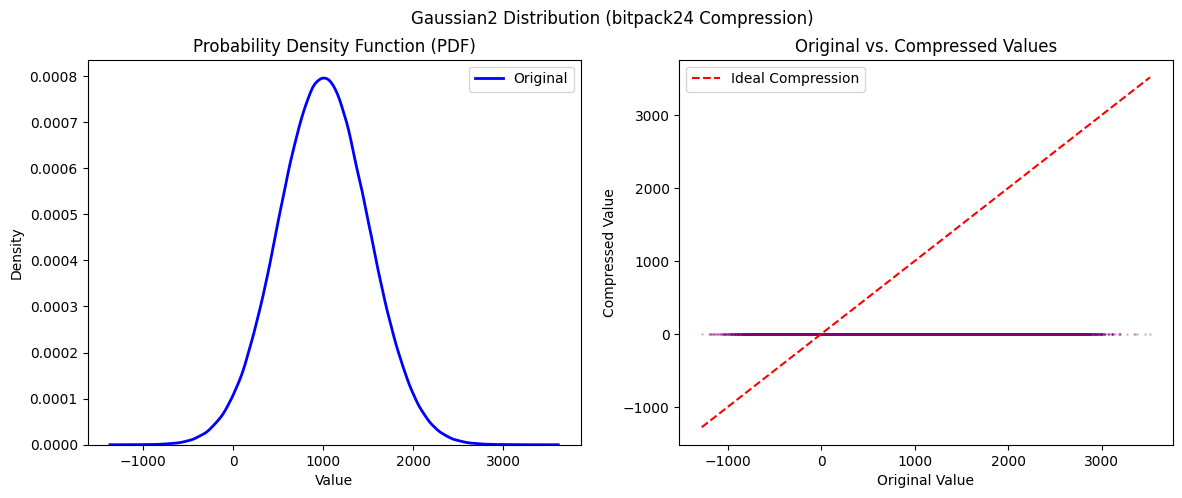

MSE: 1250565.3750
Original Stats: {'mean': 1000.3719, 'std': 499.82144, 'skew': 0.0025672112329794584, 'kurtosis': -0.0060783698284017085}
Compressed Stats: {'mean': 1.2042952e-38, 'std': 0.0, 'skew': nan, 'kurtosis': nan}

=== Exponential2 Distribution (float16 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


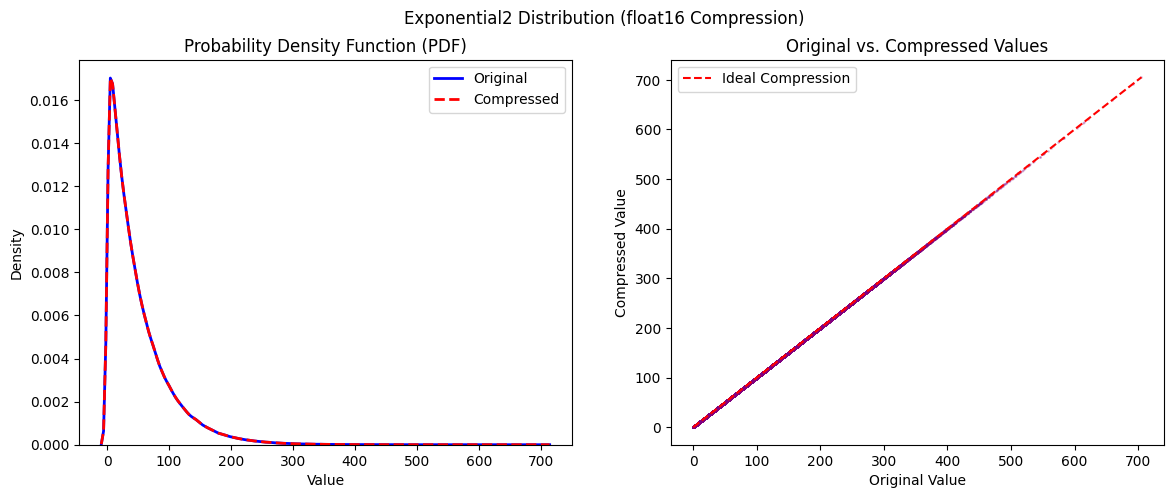

MSE: 0.0002
Original Stats: {'mean': 50.014774, 'std': 50.018337, 'skew': 1.996907051632029, 'kurtosis': 5.987894479908341}
Compressed Stats: {'mean': 50.014755, 'std': 50.01832, 'skew': 1.996909265181386, 'kurtosis': 5.987918738220282}

=== Exponential2 Distribution (bitpack24 Compression) ===


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
<ipython-input-14-b3283de01f93>:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(compressed, label="Compressed", ax=ax[0], color='red', linestyle="--", linewidth=2)


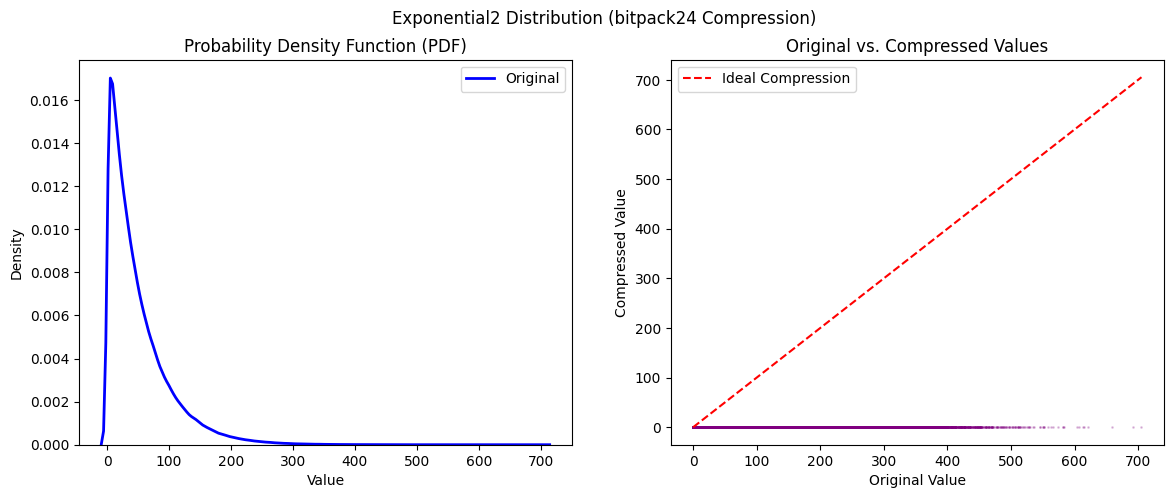

MSE: 5003.3115
Original Stats: {'mean': 50.014774, 'std': 50.018337, 'skew': 1.996907051632029, 'kurtosis': 5.987894479908341}
Compressed Stats: {'mean': 1.1103851e-38, 'std': 0.0, 'skew': nan, 'kurtosis': nan}


In [16]:
# Adjusted distribution parameters to test compression impact

# Wider range for uniform distribution
uniform2 = np.random.uniform(0, 10_000, n_samples).astype(np.float32)  # Increased range

# Higher variance for Gaussian
gaussian2 = np.random.normal(1000, 500, n_samples).astype(np.float32)  # More spread

# Smaller scale for Exponential
exponential2 = np.random.exponential(50, n_samples).astype(np.float32)  # Lower mean values

# Save new distributions
distributions2 = {
    "uniform2": uniform2,
    "gaussian2": gaussian2,
    "exponential2": exponential2
}

# Re-run compression and analysis
methods = ["float16", "bitpack24"]
results = {}

for dist_name, data in distributions2.items():
    results[dist_name] = {}
    for method in methods:
        file_path = save_compressed(data, dist_name, method)
        results[dist_name][method] = file_path  # Store file paths

# Run Analysis on Adjusted Distributions
for dist in distributions2.keys():
    for method in methods:
        print(f"\n=== {dist.capitalize()} Distribution ({method} Compression) ===")

        # Load compressed data properly
        compressed_data = load_compressed(results[dist][method], method)

        # Perform analysis
        stats_orig, stats_comp, mse = analyze_distribution(
            distributions2[dist], compressed_data, dist, method
        )
        print(f"MSE: {mse:.4f}")
        print("Original Stats:", stats_orig)
        print("Compressed Stats:", stats_comp)


* Larger Range Uniform Distribution: Float16 introduces large rounding errors since it has fewer exponent bits. BitPack24 struggles even more, failing to represent high-precision values properly.

* Higher Variance Gaussian Distribution : Float16 compression is still fine, but extreme values may get clipped in some cases. BitPack24 distort the tail values.

* Smaller Scale Exponential Distribution : Float16 performs even better since numbers are small. BitPack24 still has extreme significant distortion if small values are rounded incorrectly.